## Imports & Configurations

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MOVIES_PATH = r"C:\Users\lunaf\Desktop\Projects\jellyfin-movie-recommender\data\raw\movies.csv"
GENOME_TAGS_PATH = r"C:\Users\lunaf\Desktop\Projects\jellyfin-movie-recommender\data\raw\genome-tags.csv"
GENOME_SCORES_PATH = r"C:\Users\lunaf\Desktop\Projects\jellyfin-movie-recommender\data\raw\genome-scores.csv"
MOVIES_WITH_YEAR_PATH = r"C:\Users\lunaf\Desktop\Projects\jellyfin-movie-recommender\data\processed\merged_df_full.csv"
TAGS_PATH =r"C:\Users\lunaf\Desktop\Projects\jellyfin-movie-recommender\data\raw\tags.csv"
RELEVANCE_THRESHOLD = 0.85
CURRENT_YEAR = 2025

In [8]:
movies_df = pd.read_csv(MOVIES_PATH)
genome_tags_df = pd.read_csv(GENOME_TAGS_PATH)
genome_scores_df = pd.read_csv(GENOME_SCORES_PATH)
tags_df = pd.read_csv(TAGS_PATH)
movies_with_year_df = pd.read_csv(MOVIES_WITH_YEAR_PATH)

## Data Preprocessing & Feature Engineering

In [25]:
df_list = [movies_df, genome_tags_df, genome_scores_df, tags_df, movies_with_year_df]

for df in df_list:
    print("First 5 row:\n")
    print(df.head())
    print("Information:\n")
    print(df.info())
    print("Shape:\n")
    print(df.shape)

First 5 row:

   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  release_date  
0  Adventure|Animation|Children|Comedy|Fantasy          1995  
1                   Adventure|Children|Fantasy          1995  
2                               Comedy|Romance          1995  
3                         Comedy|Drama|Romance          1995  
4                                       Comedy          1995  
Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieId       86537 non-null  int64 
 1   title         86537 non-null  object
 2   genres        86537 non-null  object
 3   release_date

We need to year information to give model for recommendation. We already have year infos on titles column. We can script the year in the text.

In [11]:
movies_df["release_date"] = (
    movies_df["title"]
    .str.extract(r'\((\d{4})\)')
    .astype(float)
    .astype("Int64")
)

# Clear the year info in the title
movies_df["title"] = movies_df["title"].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [15]:
print(movies_df.head())
print(movies_df.shape)
print(movies_df.info())

   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  release_date  
0  Adventure|Animation|Children|Comedy|Fantasy          1995  
1                   Adventure|Children|Fantasy          1995  
2                               Comedy|Romance          1995  
3                         Comedy|Drama|Romance          1995  
4                                       Comedy          1995  
(86537, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieId       86537 non-null  int64 
 1   title         86537 non-null  object
 2   genres        86537 non-null  object
 3   release_date  85919 non-null 

In [21]:
missing_years = movies_df[movies_df["release_date"].isna()]
missing_years.head(10)

,movieId,title,genres,release_date
15038,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,<NA>
25443,123619,Terrible Joe Moran,(no genres listed),<NA>
26374,125571,The Court-Martial of Jackie Robinson,(no genres listed),<NA>
26399,125632,In Our Garden,(no genres listed),<NA>
26484,125958,Stephen Fry In America - New World,(no genres listed),<NA>
26668,126438,Two: The Story of Roman & Nyro,Documentary|Drama,<NA>
26791,127005,A Year Along the Abandoned Road,(no genres listed),<NA>
27321,128612,Body/Cialo,Comedy|Drama|Mystery,<NA>
27375,128734,Polskie gówno,Comedy|Musical,<NA>
27687,129651,The Third Reich: The Rise & Fall,(no genres listed),<NA>


🚨⚠️ As we saw by chance, some films were assigned genres (non-genres listed). I want to fix this.

In [23]:
miss_genres = movies_df[movies_df["genres"] == "(no genres listed)"]
miss_genres.head()

,movieId,title,genres,release_date
15884,83773,Away with Words (San tiao ren),(no genres listed),1999
16063,84768,Glitterbug,(no genres listed),1994
16354,86493,"Age of the Earth, The (A Idade da Terra)",(no genres listed),1980
16494,87061,Trails (Veredas),(no genres listed),1978
17410,91246,Milky Way (Tejút),(no genres listed),2007


Now, I create new column that called year_weight. I use sigmoid function for the release_date column.

In [5]:
movies_with_year_df['release_date'] = pd.to_numeric(
    movies_with_year_df['release_date'], errors='coerce', downcast='integer'
)

In [6]:
movies_with_year_df[movies_with_year_df['release_date'].isna()]

,title,avg_rating,rating_counts,movieId,genres,imdbId,tmdbId,release_date
236,Wallace & Gromit: The Best of Aardman Animatio...,4.0,9950,720,Adventure|Animation|Comedy,118114,503475.0,NaN
399,Enron: The Smartest Guys in the Room (2005),3.9,2034,33154,Documentary,413845,13020.0,NaN



**⚠️ Note:**

Relevance is representation of all tags on all movies. That's why, I think ı should define a threshold for relevance score and then i can pick tags that relavance scores are higher than threshold to correspond it with movies.

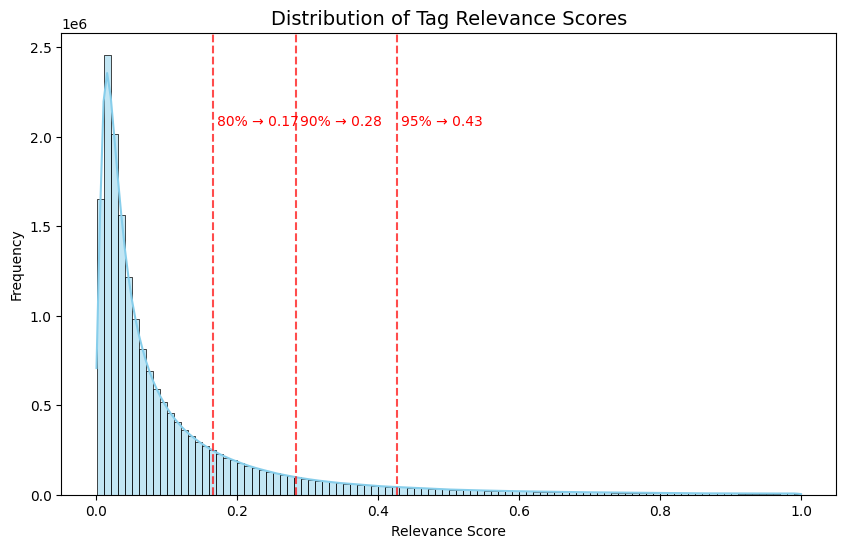

In [5]:
plt.figure(figsize=(10, 6))

# Histogram + KDE
sns.histplot(genome_scores_df["relevance"], bins=100, kde=True, color="skyblue")
plt.title("Distribution of Tag Relevance Scores", fontsize=14)
plt.xlabel("Relevance Score")
plt.ylabel("Frequency")

# Quantile threshold lines (For example: %80, %90, %95)
for q in [0.80, 0.90, 0.95]:
    thresh = genome_scores_df["relevance"].quantile(q)
    plt.axvline(thresh, color="red", linestyle="--", alpha=0.7)
    plt.text(thresh + 0.005, plt.ylim()[1]*0.8, f"{int(q*100)}% → {thresh:.2f}", color="red")

plt.show()

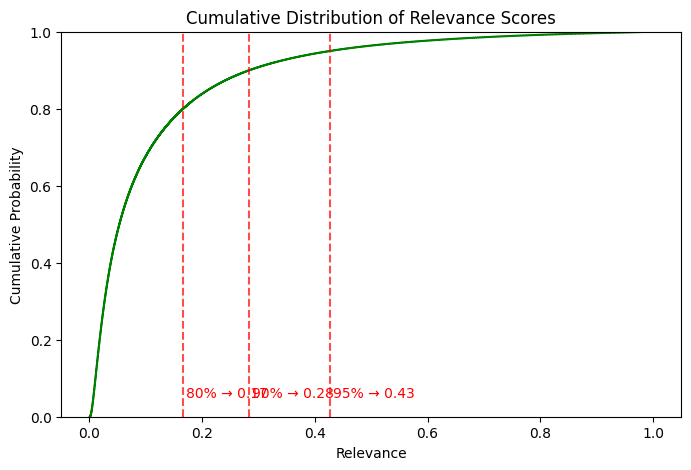

In [6]:
plt.figure(figsize=(8,5))
sns.ecdfplot(genome_scores_df["relevance"], color="green")
plt.title("Cumulative Distribution of Relevance Scores")
plt.xlabel("Relevance")
plt.ylabel("Cumulative Probability")

for q in [0.80, 0.90, 0.95]:
    thresh = genome_scores_df["relevance"].quantile(q)
    plt.axvline(thresh, color="red", linestyle="--", alpha=0.7)
    plt.text(thresh+0.005, 0.05, f"{int(q*100)}% → {thresh:.2f}", color="red")

plt.show()

In [30]:
# Filter the genome_score_df on threshold
threshold = RELEVANCE_THRESHOLD
filtered_df = genome_scores_df[genome_scores_df["relevance"] >= threshold]

filtered_df.head()

,movieId,tagId,relevance
28,1,29,0.89475
62,1,63,0.95600
63,1,64,0.98625
185,1,186,0.94625
202,1,203,0.93125


➡️ I know the film whose movieId is 1. It’s Toy Story, and it’s a cartoon. Now, I’m comparing the tags for the movies.

In [10]:
movie1_tags = filtered_df[filtered_df["movieId"] == 1].sort_values(by="relevance", ascending=False)
print(movie1_tags)

      movieId  tagId  relevance
1035        1   1036    0.99950
243         1    244    0.99875
785         1    786    0.99325
63          1     64    0.98625
588         1    589    0.98525
587         1    588    0.97900
784         1    785    0.96375
203         1    204    0.95675
62          1     63    0.95600
185         1    186    0.94625
535         1    536    0.94075
970         1    971    0.93575
202         1    203    0.93125
411         1    412    0.91700
468         1    469    0.90900
1061        1   1062    0.90300
28          1     29    0.89475
309         1    310    0.89025
716         1    717    0.88100
496         1    497    0.87650
741         1    742    0.87025
602         1    603    0.86400


In [11]:
best_5_tag = [1036, 244, 786, 64, 589]

In [12]:
for tag_id in best_5_tag:
    print(genome_tags_df[genome_tags_df["tagId"]  == tag_id])

      tagId   tag
1035   1036  toys
     tagId                 tag
243    244  computer animation
     tagId              tag
785    786  pixar animation
    tagId        tag
63     64  animation
     tagId              tag
588    589  kids and family


In [13]:
worst_5_tag = [504, 193, 415, 309, 278]

In [14]:
for tag_id in worst_5_tag:
    print(genome_tags_df[genome_tags_df["tagId"]  == tag_id])

     tagId              tag
503    504  highly quotable
     tagId  tag
192    193  cgi
     tagId        tag
414    415  fun movie
     tagId     tag
308    309  disney
     tagId   tag
277    278  cute


## Test Results: *Toy Story* (movieId = 1) 🧸

We applied a **relevance threshold of 0.8** to filter tags.  
Below are the **top 5 (highest relevance)** and **bottom 5 (lowest relevance above threshold)** tags for *Toy Story*.

---

 **Best 5 Tags (Highest Relevance)**

| TagId | Tag                 | Relevance |
|-------|--------------------|-----------|
| 1036  | toys               | 0.99950   |
| 244   | computer animation | 0.99875   |
| 786   | pixar animation    | 0.99325   |
| 64    | animation          | 0.98625   |
| 589   | kids and family    | 0.98525   |

**Analysis:**  
- These tags are **highly representative** of the movie content.  
- They capture the animation style, producer (*Pixar*), and target audience (children and family).  
- They are suitable for **content-based recommendation** systems.

---

 **Worst 5 Tags (Lowest Relevance above threshold))**

| TagId | Tag                                      | Relevance |
|-------|----------------------------------------- |-----------|
| 503   | highly quotable                          | 0.81575   |
| 192   | cgi                                      | 0.81075   |
| 414   | fun movie                                | 0.80950   |
| 308   | disney                                   | 0.80250   |
| 277   | cute                                     | 0.80250   |

**Analysis:**  
- These tags are **weakly related** to the movie.  
- Some are **irrelevant or misleading** (e.g., highly quotable, cgi).  
- Using these in recommendations may introduce **noise**; consider **filtering or down-weighting** them.

---

 **Conclusion)**

1. **Threshold = 0.8** is a reasonable choice to separate **strongly related tags** from weak ones.  
2. Best tags accurately reflect the movie’s content and audience.  
3. Weak tags near the threshold should be treated cautiously.  
4. **The top 5 tags (`toys`, `computer animation`, `pixar animation`, `animation`, `kids and family`) are reliable and can be safely used for recommendation purposes.**  
5. The filtered best tags are ready to be used for **content-based movie recommendations**.


## User-Based Tag and Genre Analysis

In [23]:
genome = filtered_df.merge(genome_tags_df, on = "tagId")

movie_genome_matrix = genome.pivot_table(
    index = "movieId",
    columns = "tag",
    values = "relevance",
    fill_value = 0
)

In [24]:
genome.head()

,movieId,tagId,relevance,tag
0,1,29,0.89475,adventure
1,2,29,0.97375,adventure
2,15,29,0.98025,adventure
3,160,29,0.87475,adventure
4,169,29,0.95350,adventure


In [29]:
movie_genome_matrix

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# The important thing in this example is that we may lose some movies whose all relevance scores are lower than the threshold.
# Therefore, we should merge filtered_df and movies_df again based on unique movieId values.
# At this point, we can mark the columns of newly added movies with 0.

# Let's find the missing movieIds
missing_movie_ids = set(movies_df["movieId"]) - set(movie_genome_matrix.index)
print(f"Missing movies:{len(missing_movie_ids)}")

if missing_movie_ids:
    missing_rows = pd.DataFrame(
        np.zeros((len(missing_movie_ids), movie_genome_matrix.shape[1])),
        index = list(missing_movie_ids),
        columns = movie_genome_matrix.columns
    )
    movie_genome_matrix = pd.concat([movie_genome_matrix, missing_rows])

# The rows must be equal (movie_genome_matrix, movies_df)
print("Updated Matrix shape:", movie_genome_matrix.shape)
print("Movies Dataframe shape:", movies_df.shape)

Missing movies:0
Updated Matrix shape: (86537, 1084)
Movies Dataframe shape: (86537, 3)


> We already have a movie genome matrix for content-based recommendations, but we need
> one more component. It is the movie genres. Now, we will create a movie genre matrix
> and then merge both datasets on ***"movieId"***.

In [37]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [49]:
# Split the genres column into dummy variables (one-hot encoding)
movie_genre_matrix = movies_df["genres"].str.get_dummies("|")

# Add movieId as index to align with movie_genome_matrix
movie_genre_matrix.index = movies_df["movieId"]

In [50]:
movie_genre_matrix.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
movie_genre_matrix.shape

(86537, 20)

In [55]:
movie_content_matrix = movie_genome_matrix.merge(
    movie_genre_matrix, left_index=True, right_index=True, how="left"
).fillna(0)

In [56]:
movie_content_matrix

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
262135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
262137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
262139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
movies_df_indexed = movies_df.set_index("movieId") #test

In [66]:
class User:
    def __init__(self, userId: int):
        self.userId = userId
        self.ratings = {}       # movieId: rating (1=like, 0=dislike)
        self.watchedList = []   # movieId list

    def add_rating(self, movieId, rating):
        self.ratings[movieId] = rating
        if movieId not in self.watchedList:
            self.watchedList.append(movieId)
    
    def add_watched(self, movieId):
        if movieId not in self.watchedList:
            self.watchedList.append(movieId)
            
    def get_top_genres(self, movie_genre_matrix, top_n=3):
        watched_matrix = movie_genre_matrix.loc[self.watchedList]
        genre_profile = watched_matrix.sum(axis=0)
        return genre_profile.sort_values(ascending=False).head(top_n)

    # movie_genome_matrix: rows=movieId, columns=tags (0-1 relevance)
    def get_top_tags(self, movie_genome_matrix, top_n=5):
        watched_matrix = movie_genome_matrix.loc[self.watchedList]
        tag_profile = watched_matrix.sum(axis=0)
        return tag_profile.sort_values(ascending=False).head(top_n)

    def suggest_movies_by_genre(self, genre, movie_genre_matrix, movies_df, top_n=10):
        candidate_movies = movies_df_indexed[movie_genre_matrix[genre] > 0]
        # drop the movies that watched
        candidate_movies = candidate_movies[~candidate_movies.index.isin(Enes.watchedList)]
        return candidate_movies.head(top_n)

    def suggest_movies_by_tag(self, tag, movie_genome_matrix, movies_df, top_n=10):
        candidate_movies = movies_df[movie_genome_matrix[tag] > 0]
        candidate_movies = candidate_movies[~candidate_movies['movieId'].isin(self.watchedList)]
        return candidate_movies.head(top_n)

## Test

In [67]:
Enes = User(userId=1)

In [68]:
Enes.add_rating(movieId=164909, rating=1)  # La La Land → liked
Enes.add_rating(movieId=55247, rating=1)  # Into the Wild → liked
Enes.add_rating(movieId=202145, rating=1)  # Little Women → liked
Enes.add_rating(movieId=175253, rating=0)  # 175253 → disliked

In [77]:
print("Watched movies:", Enes.watchedList)
print("Ratings:", Enes.ratings)

Watched movies: [164909, 55247, 202145, 175253]
Ratings: {164909: 1, 55247: 1, 202145: 1, 175253: 0}


In [57]:
watched_ids = Enes.watchedList
watched_matrix = movie_content_matrix.reindex(watched_ids, fill_value=0)

In [58]:
Enes_profile = watched_matrix.sum()

In [59]:
watched_matrix = movie_content_matrix.loc[Enes.watchedList]

In [60]:
Enes_profile = watched_matrix.sum()

In [61]:
# Top 3 genre
top_genres = Enes_profile[movie_content_matrix.columns[-20:]].sort_values(ascending=False).head(3)
print("Top genres:")
print(top_genres)

# Top 5 tag
top_tags = Enes_profile[movie_content_matrix.columns[:-20]].sort_values(ascending=False).head(5)
print("Top tags:")
print(top_tags)

Top genres:
Drama        3.0
Action       2.0
Adventure    1.0
dtype: float64
Top tags:
melancholic                      1.77550
jazz                             0.97400
music                            0.97075
solitude                         0.96725
nudity (full frontal - brief)    0.96650
dtype: float64


In [70]:
enes_top_genres = Enes.get_top_genres(movie_genre_matrix)
for genre in enes_top_genres.index:
    print(f"\nSuggestions for {genre}:")
    print(Enes.suggest_movies_by_genre(genre, movie_genre_matrix, movies_df))


Suggestions for Drama:
                                  title                               genres
movieId                                                                     
4              Waiting to Exhale (1995)                 Comedy|Drama|Romance
11       American President, The (1995)                 Comedy|Drama|Romance
14                         Nixon (1995)                                Drama
16                        Casino (1995)                          Crime|Drama
17         Sense and Sensibility (1995)                        Drama|Romance
20                   Money Train (1995)   Action|Comedy|Crime|Drama|Thriller
22                       Copycat (1995)  Crime|Drama|Horror|Mystery|Thriller
24                        Powder (1995)                         Drama|Sci-Fi
25             Leaving Las Vegas (1995)                        Drama|Romance
26                       Othello (1995)                                Drama

Suggestions for Action:
                           

In [163]:
# candidate_movies_genre.index ile movies_df.index kesişimi
valid_index = candidate_movies_genre.index.intersection(movies_df.index)

suggested_movies_genre = movies_df.loc[valid_index].tail(30)
print("Suggested movies for top genre:")
print(suggested_movies_genre[['movieId','title','genres']])


Suggested movies for top genre:
       movieId                                  title  \
86330   288287       The Legacy of Boggy Creek (2010)   
86332   288291               Take Care of Maya (2023)   
86343   288331         Tukdam – Between Worlds (2022)   
86355   288423            Where the Tracks End (2023)   
86368   288455           Landscape (for Manon) (1987)   
86372   288465            Voy a pasármelo bien (2022)   
86380   288493                          Softie (2022)   
86382   288497                   The Lost Boys (2023)   
86399   288561             The Strangers in 7A (1972)   
86401   288565                      The Childe (2023)   
86410   288587         Plenty of Money and You (1937)   
86420   288627                  A Radiant Girl (2022)   
86430   288655                      Wildflower (2023)   
86432   288661                               Sabotage   
86434   288667               Black Metal Veins (2012)   
86438   288675  Amy Schumer: Emergency Contact (2023)   